# Imports

In [1]:
from pathlib import Path
from tqdm.notebook import tqdm 

from sklearn.metrics import log_loss, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder

from category_encoders import TargetEncoder
from scipy.sparse import hstack

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
SEED = 0

# Data

Считываем данные, дропаем запрещенные столбцы. 

In [3]:
%%time

data_raw = pd.read_csv('data.csv').drop([
    "oaid_hash", 
    "banner_id0",
    "banner_id1",
    "rate0",
    "rate1",
    "g0",
    "g1",
    "coeff_sum0",
    "coeff_sum1"
], axis=1)
data_raw = data_raw.sort_values("date_time").reset_index().drop("index", axis=1)

data = data_raw.copy()
data.head()

CPU times: total: 53.1 s
Wall time: 53.1 s


,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions,clicks
0,2021-09-01 00:02:49.000000,30,596,0,0,7,1,0
1,2021-09-26 00:00:00.000000,41,29,1,3,0,1,0
2,2021-09-26 00:00:00.000000,1,188,2,2,15,1,0
3,2021-09-26 00:00:00.000000,17,52,2,2,5,1,0
4,2021-09-26 00:00:00.000000,47,73,1,4,13,1,0


Значения столбцов из readme (мне для удобства):

* date_time - время показа рекламы
* zone_id - id зоны, где зона - место на сайте для размещения рекламы
* banner_id - id баннера, где баннер - сама реклама
* campaign_clicks - общее количество показов данной кампании (которой соотвествует баннер) данному юзеру, произошедшие до текущего показа. Кампанию стоит понимать как что-то общее (рекламодатель/тематика/ и т. п.) для баннеров.
* os_id - id операционной системы
* country_id - id страны
* impressions - был ли показ
* clicks - был ли клик

# Small EDA

In [4]:
def show_column_info(df: pd.DataFrame, column_name: str):
    print(f"Column name: {column_name}")
    print(f"Missings: {df[column_name].isna().sum()}")
    print(f"Values:\n{df[column_name].value_counts()}")
    print("#"*25, "\n")

In [5]:
data.shape

(15821472, 8)

In [6]:
data.dtypes

date_time          object
zone_id             int64
banner_id           int64
campaign_clicks     int64
os_id               int64
country_id          int64
impressions         int64
clicks              int64
dtype: object

## Date_time

In [7]:
# Исправляем тип
data["date_time"] = pd.to_datetime(data['date_time'])

In [8]:
data["date_time"].describe(datetime_is_numeric=True)

count                         15821472
mean     2021-09-29 06:17:04.484696576
min                2021-09-01 00:02:49
25%                2021-09-27 10:24:02
50%                2021-09-29 02:22:11
75%                2021-09-30 21:36:15
max                2021-10-02 23:59:59
Name: date_time, dtype: object

Видим сдвиг распределения дат, посмотрим детальнее

In [9]:
show_column_info(data, column_name='date_time')

Column name: date_time
Missings: 0
Values:
2021-09-29 19:14:40    140
2021-09-26 17:08:47    134
2021-09-29 19:11:38    131
2021-09-29 19:13:10    130
2021-09-29 19:14:01    129
                      ... 
2021-10-01 17:14:18      1
2021-10-01 17:14:23      1
2021-10-01 17:14:40      1
2021-10-01 17:14:50      1
2021-09-01 00:02:49      1
Name: date_time, Length: 604712, dtype: int64
######################### 



In [10]:
# Создадим новые временные фичи
data['month'] = data['date_time'].dt.month
data['day_of_week'] = data['date_time'].dt.dayofweek
data['is_weekend'] = data['day_of_week'] >= 5
data['hour'] = data['date_time'].dt.hour
data['date'] = data['date_time'].dt.date

In [11]:
show_column_info(data, 'date') 

Column name: date
Missings: 0
Values:
2021-09-26    3102610
2021-09-29    2420588
2021-09-27    2367303
2021-09-28    2307355
2021-10-02    2128978
2021-09-30    1851189
2021-10-01    1643448
2021-09-01          1
Name: date, dtype: int64
######################### 



1 сентября каким-то образом затесалось :) 

Посмотрим как отличаются конверсии по новым временным фичам: 

In [12]:
data.groupby("month").agg({"clicks": ["mean", "std", "count"]})

clicks                    
           mean       std     count
month                              
9      0.023088  0.150183  12049046
10     0.038188  0.191650   3772426

In [13]:
data.groupby("day_of_week").agg({"clicks": ["mean", "std", "count"]})

clicks                   
                 mean       std    count
day_of_week                             
0            0.017568  0.131375  2367303
1            0.019425  0.138013  2307355
2            0.026472  0.160536  2420589
3            0.035907  0.186059  1851189
4            0.041802  0.200136  1643448
5            0.035398  0.184784  2128978
6            0.019735  0.139087  3102610

In [14]:
data.groupby("is_weekend").agg({"clicks": ["mean", "std", "count"]})

clicks                    
                mean       std     count
is_weekend                              
False       0.026975  0.162009  10589884
True        0.026109  0.159459   5231588

In [15]:
data.groupby("hour").agg({"clicks": ["mean", "std", "count"]})

clicks                   
          mean       std    count
hour                             
0     0.027127  0.162452   550788
1     0.025834  0.158639   498533
2     0.026113  0.159472   482018
3     0.026521  0.160678   444033
4     0.025041  0.156250   405813
5     0.024862  0.155706   474251
6     0.025333  0.157134   476654
7     0.025290  0.157003   481859
8     0.023467  0.151383   547525
9     0.024186  0.153626   516624
10    0.024202  0.153675   509720
11    0.024127  0.153442   592749
12    0.025647  0.158081   625483
13    0.026939  0.161906   634799
14    0.029490  0.169175   716351
15    0.030019  0.170640   744556
16    0.026836  0.161603   918587
17    0.027647  0.163960   910469
18    0.027346  0.163089  1014305
19    0.027334  0.163055  1135143
20    0.027367  0.163151  1082943
21    0.027677  0.164045   812888
22    0.028052  0.165123   667214
23    0.027348  0.163097   578167

По всем новым фичам видно, что конверсии в группах отличаются, значит, возможно, они помогут предиктивной модели (используем target encoding)

## zone_id             

Назовем самые распространенные зоны топовыми

In [16]:
show_column_info(data, column_name='zone_id')

Column name: zone_id
Missings: 0
Values:
17      2280422
14      1638642
12       736352
0        708379
19       693292
         ...   
3241          1
2705          1
3092          1
2072          1
3258          1
Name: zone_id, Length: 3444, dtype: int64
######################### 



In [17]:
top_zones = set(data["zone_id"].value_counts().head(3).index)
data["is_top3_zone"] = data["zone_id"].apply(lambda x: x in top_zones)

top_zones = set(data["zone_id"].value_counts().head(5).index)
data["is_top5_zone"] = data["zone_id"].apply(lambda x: x in top_zones)

top_zones = set(data["zone_id"].value_counts().head(20).index)
data["is_top20_zone"] = data["zone_id"].apply(lambda x: x in top_zones)

In [18]:
data.groupby("is_top3_zone").agg({"clicks": ["mean", "std", "count"]})

clicks                    
                  mean       std     count
is_top3_zone                              
False         0.022753  0.149116  11166056
True          0.036127  0.186606   4655416

In [19]:
data.groupby("is_top5_zone").agg({"clicks": ["mean", "std", "count"]})

clicks                   
                  mean       std    count
is_top5_zone                             
False         0.024600  0.154903  9764385
True          0.030055  0.170738  6057087

In [20]:
data.groupby("is_top20_zone").agg({"clicks": ["mean", "std", "count"]})

clicks                    
                   mean       std     count
is_top20_zone                              
False          0.021180  0.143984   5730971
True           0.029817  0.170082  10090501

## banner_id

In [21]:
show_column_info(data, "banner_id")

Column name: banner_id
Missings: 0
Values:
22      613367
361     387563
3       286999
18      262946
21      246378
         ...  
1587         1
1402         1
1596         1
1595         1
1470         1
Name: banner_id, Length: 1633, dtype: int64
######################### 



In [22]:
top_banners = set(data["banner_id"].value_counts().head(3).index)
data["is_top3_banner"] = data["banner_id"].apply(lambda x: x in top_banners)

top_banners = set(data["banner_id"].value_counts().head(5).index)
data["is_top5_banner"] = data["banner_id"].apply(lambda x: x in top_banners)

top_banners = set(data["banner_id"].value_counts().head(20).index)
data["is_top20_banner"] = data["banner_id"].apply(lambda x: x in top_banners)

In [23]:
data.groupby("is_top3_banner").agg({"clicks": ["mean", "std", "count"]})

clicks                    
                    mean       std     count
is_top3_banner                              
False           0.026921  0.161853  14533543
True            0.024060  0.153234   1287929

In [24]:
data.groupby("is_top5_banner").agg({"clicks": ["mean", "std", "count"]})

clicks                    
                    mean       std     count
is_top5_banner                              
False           0.026817  0.161547  14024219
True            0.025688  0.158201   1797253

In [25]:
data.groupby("is_top20_banner").agg({"clicks": ["mean", "std", "count"]})

clicks                    
                     mean       std     count
is_top20_banner                              
False            0.026545  0.160750  10999856
True             0.027015  0.162126   4821616

## campaign_clicks

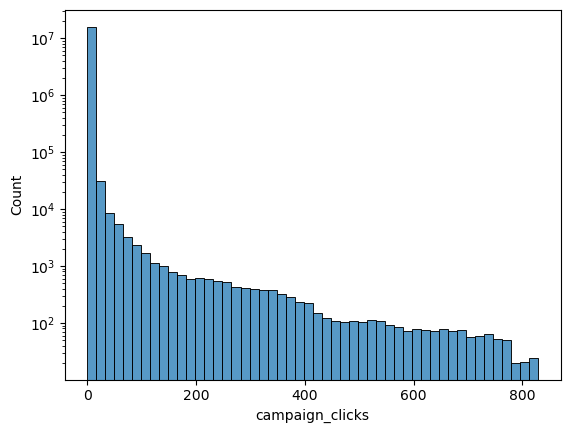

In [26]:
sns.histplot(data["campaign_clicks"], log=True, bins=50);

Много маленьких и больших значений, прологарифмируем эту фичу

In [27]:
data["campaign_clicks"] = np.log(data["campaign_clicks"] + 1e-4)

## os_id

In [28]:
data.groupby("os_id").agg({"clicks": ["mean", "std", "count"]})

clicks                   
           mean       std    count
os_id                             
0      0.030062  0.170758  3856798
1      0.013518  0.115480  3178693
2      0.017832  0.132340  4589979
3      0.048044  0.213859   759767
4      0.039583  0.194977  3012541
5      0.053302  0.224637   111946
6      0.063603  0.244045   310346
7      0.030303  0.172292       99
8      0.024352  0.154200     1273
9      0.000000  0.000000       25
10     0.000000  0.000000        5

Конверсии в зависимости от ОС отличаются, уникальных значений немного, значит сможем сделать OHE этой фичи 

## country_id

In [29]:
data.groupby("country_id").agg({"clicks": ["mean", "std", "count"]})

clicks                   
                mean       std    count
country_id                             
0           0.027367  0.163151  4956393
1           0.035275  0.184475  1346321
2           0.033468  0.179855    66542
3           0.027723  0.164177  1337392
4           0.025620  0.157998   388801
5           0.022599  0.148621  1910054
6           0.016814  0.128573  1582705
7           0.026797  0.161488  1525569
8           0.044237  0.205621   210211
9           0.030761  0.172668   439004
10          0.018531  0.134860   356490
11          0.029866  0.170219   212245
12          0.023582  0.151742   478038
13          0.051411  0.220835   190855
14          0.026636  0.161017   138385
15          0.020661  0.142248   603301
16          0.078443  0.268869    79166

Аналогично os_id.

## impressions

In [30]:
show_column_info(data, "impressions")

Column name: impressions
Missings: 0
Values:
1    15821472
Name: impressions, dtype: int64
######################### 



Столбец содержит только одно значение, дропнем его.

In [31]:
data.drop('impressions', axis=1, inplace=True)

## clicks

In [32]:
print(f"Global conversion: {data['clicks'].mean(): .4f}")

Global conversion:  0.0267


Датасет несбалансирован по целевой переменной, учтем это при построении модели

# Preprocessing

In [33]:
def preprocessing(data: pd.DataFrame, train_indices, test_indices):
    #### Конструируем фичи, описанные в EDA
    # Неинформативная фича
    data = data.drop("impressions", axis=1)
    
    # Логарифмируем
    data["campaign_clicks"] = np.log(data["campaign_clicks"] + 1e-3)
    
    # Временные фичи
    data["date_time"] = pd.to_datetime(data['date_time'])
    data['month'] = data['date_time'].dt.month
    data['day_of_week'] = data['date_time'].dt.dayofweek
    data['day_of_week_t'] = data['date_time'].dt.dayofweek
    data['is_weekend'] = data['day_of_week'] >= 5
    data['hour'] = data['date_time'].dt.hour
    data['hour_t'] = data['date_time'].dt.hour
    
    
    ##### Все считаем по трейну чтобы не было ликов
    # Флаги на топовые зоны \ баннеры
    top_zones = set(data["zone_id"][train_indices].value_counts().head(3).index)
    data["is_top3_zone"] = data["zone_id"].apply(lambda x: x in top_zones)

    top_zones = set(data["zone_id"][train_indices].value_counts().head(5).index)
    data["is_top5_zone"] = data["zone_id"].apply(lambda x: x in top_zones)

    top_zones = set(data["zone_id"][train_indices].value_counts().head(20).index)
    data["is_top20_zone"] = data["zone_id"].apply(lambda x: x in top_zones)
    
    top_banners = set(data["banner_id"][train_indices].value_counts().head(3).index)
    data["is_top3_banner"] = data["banner_id"].apply(lambda x: x in top_banners)

    top_banners = set(data["banner_id"][train_indices].value_counts().head(5).index)
    data["is_top5_banner"] = data["banner_id"].apply(lambda x: x in top_banners)

    top_banners = set(data["banner_id"][train_indices].value_counts().head(20).index)
    data["is_top20_banner"] = data["banner_id"].apply(lambda x: x in top_banners)
    
    
    # OHE категориальных фичей
    cat_features = ["zone_id", 'month', 'os_id', 'country_id', 'hour', 'day_of_week', "banner_id"]
    ohe_encoder = OneHotEncoder(handle_unknown='ignore', sparse=True, drop='first')
    X_train_cat = ohe_encoder.fit_transform(data[cat_features].iloc[train_indices])
    X_test_cat = ohe_encoder.transform(data[cat_features].iloc[test_indices])

    
    # Target Encoding
    target_encoder = TargetEncoder(cols=["hour_t", 'day_of_week_t', 'month', 'os_id', 'country_id'])
    target_encoder.fit(data.iloc[train_indices], data.iloc[train_indices]['clicks'])
    data = target_encoder.transform(data)

    
    y_train, y_test = data["clicks"][train_indices], data["clicks"][test_indices]
    data = data.drop(["clicks", "date_time", "zone_id", "banner_id"], axis=1)
    X_train, X_test = data.iloc[train_indices], data.iloc[test_indices]
    X_train = hstack((X_train_cat.astype(float), np.array(X_train).astype(float)))
    X_test = hstack((X_test_cat.astype(float), np.array(X_test).astype(float)))
    weights = dict(y_train.value_counts())
    return X_train, X_test, y_train.values, y_test.values, weights

# Create model

In [34]:
def create_model(**kwargs):
    return LogisticRegression(solver='liblinear', random_state=SEED, **kwargs)

# Train

Используем TimeSeries валидацию чтобы избежать заглядывания в будущее некоторыми фичами.

In [35]:
%%time

data = data_raw.copy()

tscv = TimeSeriesSplit(n_splits=5)

results = []
for C in tqdm([0.001, 0.01, 0.1, 1.0]):
    for penalty in ['l2', 'l1']:
        lloss_list = []
        rocauc_list = []
        for train_index, test_index in tscv.split(data):
            X_train, X_test, y_train, y_test, weights = preprocessing(data, train_index, test_index)
            logreg = create_model(class_weight=weights, C=C, penalty=penalty)
            logreg.fit(X_train, y_train)
            y_pred = logreg.predict_proba(X_test)[:, 1]

            lloss = log_loss(y_test, y_pred)
            rocauc = roc_auc_score(y_test, y_pred)
            lloss_list.append(lloss)
            rocauc_list.append(rocauc)

        lloss = np.mean(lloss)
        rocauc = np.mean(rocauc)
        res = {"C": C, "penalty": penalty, "lloss": lloss, "rocauc": rocauc}
        print(res)
        results.append(res)

  0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\serge\miniconda3\envs\hse_recsys39\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\serge\miniconda3\envs\hse_recsys39\lib\site-packages\category_encoders\target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\serge\miniconda3\envs\hse_recsys39\lib\site-packages\category_encoders\target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\serge\miniconda3\envs\hse_recsys39\lib\site-packages\sklearn\preprocessing\_encoders

{'C': 0.001, 'penalty': 'l2', 'lloss': 0.24577471498121198, 'rocauc': 0.7800594665264641}


C:\Users\serge\miniconda3\envs\hse_recsys39\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\serge\miniconda3\envs\hse_recsys39\lib\site-packages\category_encoders\target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\serge\miniconda3\envs\hse_recsys39\lib\site-packages\category_encoders\target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\serge\miniconda3\envs\hse_recsys39\lib\site-packages\sklearn\preprocessing\_encoders

{'C': 0.001, 'penalty': 'l1', 'lloss': 0.25248510821464526, 'rocauc': 0.7589162680279247}


C:\Users\serge\miniconda3\envs\hse_recsys39\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\serge\miniconda3\envs\hse_recsys39\lib\site-packages\category_encoders\target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\serge\miniconda3\envs\hse_recsys39\lib\site-packages\category_encoders\target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\serge\miniconda3\envs\hse_recsys39\lib\site-packages\sklearn\preprocessing\_encoders

{'C': 0.01, 'penalty': 'l2', 'lloss': 0.24658957338549412, 'rocauc': 0.7810853553570798}


C:\Users\serge\miniconda3\envs\hse_recsys39\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\serge\miniconda3\envs\hse_recsys39\lib\site-packages\category_encoders\target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\serge\miniconda3\envs\hse_recsys39\lib\site-packages\category_encoders\target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\serge\miniconda3\envs\hse_recsys39\lib\site-packages\sklearn\preprocessing\_encoders

{'C': 0.01, 'penalty': 'l1', 'lloss': 0.25513444387665307, 'rocauc': 0.7578762400530562}


C:\Users\serge\miniconda3\envs\hse_recsys39\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\serge\miniconda3\envs\hse_recsys39\lib\site-packages\category_encoders\target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\serge\miniconda3\envs\hse_recsys39\lib\site-packages\category_encoders\target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\serge\miniconda3\envs\hse_recsys39\lib\site-packages\sklearn\preprocessing\_encoders

{'C': 0.1, 'penalty': 'l2', 'lloss': 0.24656370305221406, 'rocauc': 0.7786132148800391}


C:\Users\serge\miniconda3\envs\hse_recsys39\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\serge\miniconda3\envs\hse_recsys39\lib\site-packages\category_encoders\target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\serge\miniconda3\envs\hse_recsys39\lib\site-packages\category_encoders\target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\serge\miniconda3\envs\hse_recsys39\lib\site-packages\sklearn\preprocessing\_encoders

{'C': 0.1, 'penalty': 'l1', 'lloss': 0.25611556002027136, 'rocauc': 0.7578092919078011}


C:\Users\serge\miniconda3\envs\hse_recsys39\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\serge\miniconda3\envs\hse_recsys39\lib\site-packages\category_encoders\target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\serge\miniconda3\envs\hse_recsys39\lib\site-packages\category_encoders\target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\serge\miniconda3\envs\hse_recsys39\lib\site-packages\sklearn\preprocessing\_encoders

{'C': 1.0, 'penalty': 'l2', 'lloss': 0.24710086448270857, 'rocauc': 0.7807069578669608}


C:\Users\serge\miniconda3\envs\hse_recsys39\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [0, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\serge\miniconda3\envs\hse_recsys39\lib\site-packages\category_encoders\target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\serge\miniconda3\envs\hse_recsys39\lib\site-packages\category_encoders\target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
C:\Users\serge\miniconda3\envs\hse_recsys39\lib\site-packages\sklearn\preprocessing\_encoders

{'C': 1.0, 'penalty': 'l1', 'lloss': 0.2569616713965023, 'rocauc': 0.7577596686201247}
CPU times: total: 1h 51min 14s
Wall time: 1h 43min 58s


# Results

In [37]:
result_df = pd.DataFrame(data=results).sort_values("rocauc", ascending=False)
result_df.head(10)

,C,penalty,lloss,rocauc
2,0.010,l2,0.246590,0.781085
6,1.000,l2,0.247101,0.780707
0,0.001,l2,0.245775,0.780059
4,0.100,l2,0.246564,0.778613
1,0.001,l1,0.252485,0.758916
3,0.010,l1,0.255134,0.757876
5,0.100,l1,0.256116,0.757809
7,1.000,l1,0.256962,0.757760


In [38]:
result_df.to_csv("hw1_results.csv")

Итого лучшее значение метрики rocauc = 0.781085, что выше 0.5 для baseline модели